## Exploration 2. 뉴스 요약봇 만들기

# Project 'News Summarizer'
- **뉴스기사 요약**
- 추상적 요약 Abstractive Summarization과 추출적 요약 Extractive Summarization을 모두 활용

---

**[진행 과정]**
1. 데이터 수집
    - 뉴스기사 데이터 사용 
2. 데이터 전처리(추상적 요약)
    - 불용어 제거, 정규화, 정수인코딩 등의 데이터 전처리
3. 모델 설계(추상적 요약)
    - 인코더, 디코더, 어텐션 설계하고 코드로 구현
4. 모델 훈련(추상적 요약)
    - EarlyStopping 적용해서 훈련
    1) 인퍼런스 모델 구현
        - 정수 인덱스 행렬로 나온 결과값을 실제 데이터로 복원하는 인퍼런스 모델 구현
5. 모델 테스트(추상적 요약) 
    - 모델을 통해 얻은 요약문과 실제 요약문 비교
6. 추출적 요약
    - summa 패키지를 사용해서 추출적 요약 시도
    
**참고 : 추가로 찾거나 공부한 자료에 대해서는 💡 표시를 붙임**

---

💡
# 텍스트 요약
- 요약 전후에 정보 손실 발생이 최소화되어야 함 = 정보 압축

**1. 추출적 요약 Extractive Summarization**

- 전통 머신러닝 `TextRank` 알고리즘 사용
- 원문에서 문장 추출 => 문장분류(text classification)
- 결과로 나온 문장들 간의 호응이 자연스럽지 않을수 있음<br>
    [적용]
네이버뉴스 요약봇

**2. 추상적 요약 Abstractive Summarization**

- 새로운 문장을 생성 => 자연서 생성(Natural Language Generation, NGL)
- RNN 활용

---

# RNN
- Long term dependencies 장기의존성 문제 => 해결하기위해 LSTM -> GRU -> Attention 등장

**Google Brain team - [Text summarization with TensorFlow](https://research.googleblog.com/2016/08/text-summarization-with-tensorflow.html)**
- DistBelief
- 역문서빈도 IDF
- seq2seq (sequence-to-sequence)

---

# seq2seq
- 두 개의 RNN 아키텍처를 사용해서 입력시퀀스로부터 출력시퀀스를 생성하는 자연어생성모델
<a href="https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5"><img src='https://miro.medium.com/v2/resize:fit:1360/format:webp/1*Cu49wPEpWJPoI0a5AV9Q1Q.png' ></a>
    1. RNN encoder : 원문 입력 -> 하나의 고정된 벡터로 변환
        - context vector : 문맥을 가진 벡터
    2. RNN decoder : 컨텍스트 벡터를 입력받아 한 단어씩 생성하고 요약 문장 완성


- 학습에서는 vanila RNN 대신 LSTM 사용
<a href='https://colah.github.io/posts/2015-08-Understanding-LSTMs/'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png' width=70% height=70%></a>   


- 인코더 마지막 time step의 hidden state를 context vector로 사용



## LSTM vs Vanila RNN
- 다음 time step 셀에 hidden state(h) + cell state(c)
- 인코더가 디코더에 전달하는 context vector에 h, c 둘다 존재


## Attentional seq2seq
<a href='https://arxiv.org/pdf/1812.02303.pdf'><img src='./img/attention.png' width=60% height=60%></a>
- seq2seq + attention mechanism
- 인코더의 **모든 step**의 hidden state 정보를 context vector로 사용
- 인코더 hidden state 가중치는 **디코더의 현재 스텝이 어디**냐에 따라 계속 달라짐

# 👉 정리

1. **seq2seq + LSTM + attention 사용**
    - 2개 LSTM을 붙여서 사용
    - encoder의 hidden state의 중요도(가중치)를 취합한 context vector는 decoder 스텝별로 계산
    - 계산된 context vector를 이용해서 decoder는 다음 등장할 단어를 예측
2. **hidden state + cell state 모두 사용**
    - cell state?
3. **decoder 앞: SOS start token / 뒤 : EOS end token 추가**

---

In [1]:
# library version check
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


---

## 💡 NLTK
- Natural Language Toolkit
- 영어 기호, 통계, 자연어처리를 위한 라이브러리


`stopwords` 
- I, my, me, over, 조사, 접미사 등 불용어 정리

---

In [2]:
# necessary library 
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

print("*")

*


---

# `추상적 요약 Abstractive Summarization`

# Step 1. 데이터 준비
- 뉴스 기사 데이터 : [news_summary_more.csv](https://github.com/sunnysai12345/News_Summary)


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
# data check
data.sample(10)

,headlines,text
86639,NASA to launch first-ever mission to study neu...,NASA is launching the world's first mission to...
67439,International Chole Bhature Day celebrated on ...,The annual International Chole Bhature Day was...
95307,Ayodhya issue cannot be resolved by talks: Mul...,Samajwadi Party Founder Mulayam Singh Yadav ha...
87925,Russian helicopters' 'Make in India' cost 250%...,The cost of Russian Kamov light-utility choppe...
7359,"Come on, kill me: Owaisi after BJP leader dare...",After Telangana BJP leader T Raja Singh dared ...
805,Cow dung thrown at National Award-winning dire...,National Award-winning Malayali filmmaker Priy...
3124,Raise parliamentarians' salary to reduce corru...,BJP MP Harish Dwivedi has urged PM Narendra Mo...
23260,Student sodomised by 6 seniors in Ajmer's Mayo...,A grade 11 student from Ajmer's Mayo College w...
95753,Air India body slams promoting pilot who misse...,The Air India pilots' association has proteste...
56443,2 teachers suspended for spelling errors in En...,Two Rajasthan government school teachers have ...


- 데이터는 `text` `headlines` 두가지 열로 구성되어있다
- 추상적 요약에서는 아래와 같이 데이터를 활용
    - `text`: 원문
    - `headlines`: 요약 데이터
- 추출적 요약에서는 text 데이터만 사용

In [5]:
len(data)

98401

- data 총 98,401개

---
# Step 2. Data preprocessing
## 1) Remove duplicate & Null values

- `df.nunique()` : 중복데이터 제외한 데이터 수 확인 
- `df.drop_duplicates()` : 중복데이터 삭제
    - `subset` : 특정 열에 대한 중복데이터를 삭제하고 싶을때 설정 
    > **subset : column label or sequence of labels, optional**<br>
      Only consider certain columns for identifying duplicates, by default use all of the columns. [ref](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)
    - `inplace=True` : 데이터프레임 내부를 직접 수정
    

- `df.isnull().sum()` : df에 Null 값이 총 몇개 있는지 확인
- `df.dropna()` : 데이터프레임 Null 제거
    - `axis=` : 삭제할 방향 정하기

In [6]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- 총 데이터 수는 98401이라 각 열에 중복된 데이터들이 있는걸 확인할수 있다

In [7]:
# 중복 샘플 제거
data.drop_duplicates(subset=['text'], inplace=True)
print('total samples:', len(data))

total samples: 98360


In [8]:
# 데이터에 null 있는지 다시 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- null 데이터도 없이 깔끔하게 정리완료

## 2) Text normalization
- `it'll` `it will` / `mustn't` `must not` 같은 표현 서로 같은거라고 설정해주기
- [텍스트 정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python) 데이터를 활용

In [9]:
# 텍스트 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


## 3) Remove `Stopwords` + etc
`stopwords` 불용어
- 텍스트에는 자주 등장하지만 자연어 처리할때 도움이 되지 않는 단어들

**etc**
- text to lowercase
- remove html tag
- remove special characters


In [10]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
print('# of stopwords: ', len(stopwords.words('english')))
print(stopwords.words('english'))

# of stopwords:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 's

- stopwords는 모두 179개가 있다

### `preprocess_sentence()` 데이터 전처리 함수

In [12]:
# data preprocessing function - stopwords + etc
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거 : <br />, <a href = ...> 등 
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 : e.g. my husband (and myself!) for => my husband
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거 : e.g. roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경 : e.g. ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    # 짧은 텍스트의 경우 불용어가 있어야 자연스럽기때문
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('*')

*


In [13]:
# test fucntion
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않는다

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


---

💡
###  `preprocess_data()` 데이터 전처리 속도 개선 함수
- 데이터 전처리 시간이 매우 오래걸렸는데 [지난 기수 그루의 코드](https://github.com/jangjs1103/laboratory/blob/main/AIFFEL/LMS/Exploration_10/Exploration_10_%EC%9A%94%EC%95%BD%EB%AC%B8.ipynb)를 참고해서 속도를 높이는 시도를 해본다
- 자세한 진행방법은 이해하기 어려웠지만, **멀티프로세싱을 할수 있도록 cpu 코어수에 맞춰서 데이터를 배분**하는 방식이었다.
- 또 **map 함수에 여러 인자를 넣어줄수 있는 라이브러리**가 따로 있다는걸 알게되어 신기했다!
    - [`partial` 참고 자료](https://tempdev.tistory.com/36)

In [14]:
import multiprocessing as mp   # 전처리 속도를 획기적으로 줄여줄 멀티 프로세싱
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # multiprocessing.Pool의 map()에 여러 인자를 넣어줄 수 있게 해줌

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

# 속도개선 함수
def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 확인
    print("# of cores: ", num_cores)

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리
    
    pool = Pool(num_cores)
    
    # partial을 이용해서 map 함수에 여러 인자 전달
    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split)) # 각자 작업한 데이터를 하나로 연결
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    
    return processed_data

# text 전처리
clean_text = preprocess_data(data['text'])
print(clean_text)

# headlines 전처리
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 불용어 제거하지 않음
print(clean_headlines)

# of cores:  4
372.938499212265  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film scr

- text 데이터 전처리 시간이 370초=**6분**이 소요되었다
- 이전 노드에서 진행한 데이터 양과 비교했을때 비슷하니 조금 더 빨라진게 아닐까..? 

In [15]:
# 중간과정 데이터 복사 - 불용어 삭제 전 데이터
origin_data = data.copy()

In [16]:
# 기존 데이터를 전처리된 데이터로 변환
data['text'] = clean_text
data['headlines'] = clean_headlines

In [17]:
# 빈 데이터 있는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
# 전처리 후의 데이터 수 확인
print('total samples:', len(data))

total samples: 98360


- 최종 데이터 수는 98360개

## 4) 데이터 샘플의 분포 시각화
- Text, Summary의 최소, 최대, 평균 길이를 구하고, 길이 분포 시각화


[text]의 최소 길이 : 1
[text]의 최대 길이 : 60
[text]의 평균 길이 : 35.09968483123221
[headlines]의 최소 길이 : 1
[headlines]의 최대 길이 : 16
[headlines]의 평균 길이 : 9.299532330215534


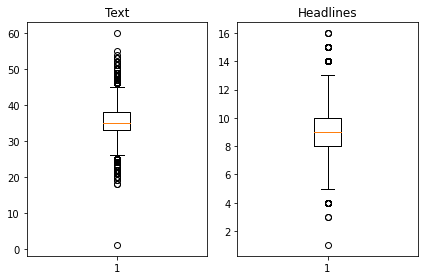

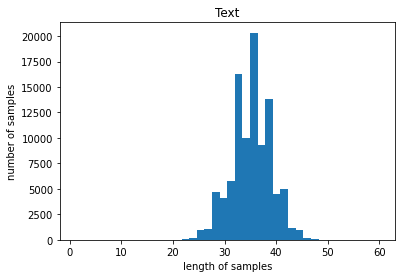

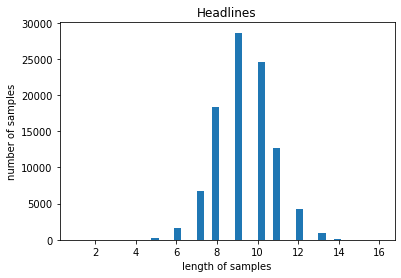

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

# data length in each row
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('[text]의 최소 길이 : {}'.format(np.min(text_len)))
print('[text]의 최대 길이 : {}'.format(np.max(text_len)))
print('[text]의 평균 길이 : {}'.format(np.mean(text_len)))
print('[headlines]의 최소 길이 : {}'.format(np.min(headlines_len)))
print('[headlines]의 최대 길이 : {}'.format(np.max(headlines_len)))
print('[headlines]의 평균 길이 : {}'.format(np.mean(headlines_len)))

# boxplot
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

# histogram
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

---

💡
[`Series.str.split()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html)
- ()안에 넣은 인자를 중심으로 str을 분리하는 메서드인데, 여기에서는 아무 값도 넣지 않았기 때문에 전체 str을 추출하게 된다.
> Pandas `str.split()` method can be applied to a whole series.
- python의 `split()` 메서드는 `str`만 적용이 가능하고, 지금 데이터는 series이기 때문에 pandas의 `str.split()`을 사용한다. 
    - 위 코드를 보면 `[len(s.split()) for s in df['Text']` lambda형태로 작성했는데, `s`:str을 꺼내서 s.split()을 한다. 
> Return value :Series of list or Data frame depending on expand Parameter
- 우리는 리스트로 만들었기때문에 아래와 같은 형태의 데이터가 만들어진다.

- *그런데, str 을 붙이지 않고 사용해도되는건가? 위에 코드에서 s 는 series 그 자체의 값 같은데, 확인을 해봐야겠다.*

In [23]:
# text_len, headlines_len 확인
text_len, headlines_len

([39,
  45,
  38,
  34,
  33,
  34,
  35,
  35,
  27,
  34,
  33,
  42,
  32,
  38,
  35,
  39,
  36,
  32,
  34,
  36,
  34,
  40,
  32,
  36,
  39,
  35,
  29,
  34,
  38,
  39,
  38,
  36,
  43,
  42,
  34,
  40,
  36,
  35,
  38,
  31,
  38,
  40,
  35,
  38,
  38,
  32,
  33,
  35,
  36,
  36,
  39,
  35,
  1,
  24,
  32,
  36,
  38,
  34,
  40,
  40,
  35,
  43,
  30,
  38,
  41,
  41,
  37,
  34,
  34,
  44,
  37,
  40,
  40,
  34,
  38,
  36,
  34,
  34,
  40,
  35,
  39,
  37,
  45,
  37,
  33,
  35,
  36,
  38,
  37,
  36,
  35,
  32,
  32,
  31,
  27,
  28,
  34,
  33,
  33,
  36,
  39,
  42,
  35,
  40,
  42,
  36,
  39,
  33,
  35,
  33,
  45,
  34,
  34,
  36,
  35,
  37,
  32,
  36,
  34,
  36,
  38,
  38,
  39,
  35,
  36,
  31,
  39,
  44,
  40,
  41,
  36,
  33,
  35,
  36,
  32,
  33,
  27,
  43,
  38,
  37,
  34,
  33,
  37,
  31,
  41,
  34,
  36,
  35,
  36,
  31,
  34,
  35,
  39,
  41,
  38,
  41,
  32,
  38,
  35,
  32,
  33,
  36,
  38,
  39,
  33,
  34,
  38,

In [24]:
len(text_len)

98360

In [22]:
check_len = [len(s.str.split()) for s in data['text']]
len(text_len), len(check_len)

AttributeError: 'str' object has no attribute 'str'

- 여기에서 사용한건 **python의 split 함수**다!
- 다시 코드를 진행한다:)

---

In [25]:
# 데이터 형태 확인
data['text'].head()

0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object

- 각 row에 있는 데이터의 길이가 text_len, headlines_len에 담겨있다.
- 노드에서 진행했던 kaggle의 데이터는 샘플별로 길이 차이가 커서 위 그래프 결과를 참고로 `max_len`를 설정하고 이 값을 기준으로 데이터를 제외시키고 정수 인코딩을 진행했다. 따라서 진행해본다.<br>
    (*사실 이 길이를 조정하는 작업을 왜 하는지 정확한 이해가 부족한데 찬찬히 이후 NLP프로젝트도 진행하면서 공부를 쌓아가보려고한다*)

In [30]:
# set max length
text_max_len = 45       # text 평균길이: 35,최대길이: 60
headlines_max_len = 15  # head 평균길이: 9, 최대길이: 16

### `below_threshold_len` : max length 로 데이터 몇 %가 해당하는지 확인하는 함수

In [27]:
# max length 로 데이터 몇 %가 해당하는지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt=0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [31]:
# check percentage
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


- max length 기준으로 데이터 99% 이상이 해당한다.
- 추가 작업을 진행하지 않아도 될것 같아서 max length를 기준으로 초과 데이터를 삭제하는 부분은 패스해도 될것같다

## 5) Add SOS start token & EOS end token
- decoder에 SOS, EOS token 추가

---


### 💡 Start token , End token
<a href='https://arxiv.org/pdf/1812.02303.pdf'><img src='./img/seq2seq_token.png' width=40% height=40%></a>
- 훈련데이터의 예측 대상 시퀀스의 앞, 뒤에는 시작토큰, 종료 토큰을 넣어주는 전처리를 통해 어디에서 멈춰야하는지 지정해야함

In [32]:
# add SOS, EOS at headlines data - 새로운 열로 추가한다
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

# check data
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


# Step 3. Seperate data
- numpy array로 변환해서 numpy slicing 기능 사용 [참고-텍스트 데이터 분리방법](https://wikidocs.net/33274)
- train:test를 8:2 비율로 분리

In [33]:
# change dataframe to numpy array 
encoder_input = np.array(data['text']) # input data of encoder
decoder_input = np.array(data['decoder_input']) # input data of decoder
decoder_target = np.array(data['decoder_target']) # label data of decoder

# shape 확인
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


In [34]:
# encoder_input 과 1)크기, 형태가 같은 , 2)순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[32539 92635 71821 ... 62569 58637 40158]


In [35]:
# 원래 데이터 확인
encoder_input[:4], decoder_input[:4], decoder_target[:4]

(array(['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
        'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
        'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
        'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customer

In [36]:
# 위의 정수 시퀀스를 이용해서 데이터 샘플 순서를 정의해줌
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
print("*")

*


In [37]:
decoder_target = decoder_target[indices]
print("*")

*


In [38]:
# 바뀐 데이터 확인
encoder_input[:4], decoder_input[:4], decoder_target[:4]

(array(['us navy veteran sentenced life imprisonment killing indian engineer srinivas kuchibhotla hate crime kansas city bar february last year veteran also sentenced months imprisonment attempted murder two others heard shouting get country shooting kuchibhotla',
        'many lakh teaching positions vacant government run schools across uttar pradesh rti query revealed state lakh teaching positions primary upper primary government schools lakh positions yet filled notably primary upper primary schools run state one teacher',
        'customary inauguration letter former us president barack obama left successor donald trump revealed obama left four pieces advice trump letter urging trump sustain international order build ladders success hard working people obama advised trump protect democratic institutions traditions',
        'bjp mla mithilesh kumar tiwari monday called congress president rahul gandhi rjd leader tejashwi yadav bunty babli remark purportedly refers movie bunty aur ba

- indexing을 한다고 생각하면 될것같다. 해당 순서의 index를 가진 df 를 만들어내는거라고 이해했다.


- 말이 안되는 단어들이 꽤 보여서 찾아봤더니 약어표현들이다
    - `bjp`: The Bharatiya Janata Party is a political party in India
    - `mla`, `dubs` ..
    - [인도 정치 관련 뉴스](https://indianexpress.com/article/political-pulse/bjp-dubs-arrest-1992-riot-case-karnataka-witch-hunt-against-hindus-links-ram-temple-event-9092233/)에서 사용되는 단어이다

In [39]:
# [전체 데이터 크기 * 0.2]로 테스트 데이터 크기 정의 (20%)
n_of_val = int(len(encoder_input)*0.2)
print('# of test data:', n_of_val)

# of test data: 19672


- 전체 데이터의 20%인 **19672개**가 test 데이터 개수가 된다

In [40]:
# separate data

# 거꾸로 indexing
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


# Step 4. 단어 집합(vocabulary)만들기 & 정수 인코딩

- 데이터의 단어를 모두 '정수'로 바꿔야 컴퓨터가 인식할수 있다
- **각 단어에 고유한 정수**를 매핑 => `단어 집합(vocabulary)`을 만드는 과정

**[참고]**
- [위키독스](https://wikidocs.net/31766)

## 1) 단어집합 vocabulary 생성
- keras의 `tokenizer` 사용


**[참고]**
- [keras doc](https://keras.io/api/keras_nlp/tokenizers/tokenizer/)
- [위키독스](https://wikidocs.net/182469)

### text data 

In [41]:
# make vocabulary with keras tokenizer
src_tokenizer = Tokenizer()

# encoder input train -> vocab
src_tokenizer.fit_on_texts(encoder_input_train)

In [42]:
# check data vocab
help(src_tokenizer)

Help on Tokenizer in module keras_preprocessing.text object:

class Tokenizer(builtins.object)
 |  Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0, **kwargs)
 |  
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolea

- 출력해서 보려고했는데 쉽지 않다. 일단 노드를 마친후에 추가공부를 해봐야겠다

- 생성된 vocabulary는 `src_tokenizer.word_index`에 저장되어 있다

In [43]:
src_tokenizer.word_index

{'said': 1,
 'india': 2,
 'year': 3,
 'added': 4,
 'us': 5,
 'also': 6,
 'first': 7,
 'government': 8,
 'police': 9,
 'people': 10,
 'indian': 11,
 'two': 12,
 'old': 13,
 'minister': 14,
 'film': 15,
 'president': 16,
 'one': 17,
 'world': 18,
 'crore': 19,
 'court': 20,
 'state': 21,
 'would': 22,
 'reportedly': 23,
 'years': 24,
 'new': 25,
 'time': 26,
 'former': 27,
 'delhi': 28,
 'last': 29,
 'three': 30,
 'reports': 31,
 'company': 32,
 'like': 33,
 'based': 34,
 'earlier': 35,
 'congress': 36,
 'man': 37,
 'bjp': 38,
 'country': 39,
 'team': 40,
 'trump': 41,
 'claimed': 42,
 'day': 43,
 'modi': 44,
 'chief': 45,
 'pakistan': 46,
 'accused': 47,
 'singh': 48,
 'pm': 49,
 'actor': 50,
 'women': 51,
 'million': 52,
 'according': 53,
 'allegedly': 54,
 'made': 55,
 'friday': 56,
 'wednesday': 57,
 'pradesh': 58,
 'tuesday': 59,
 'party': 60,
 'comes': 61,
 'monday': 62,
 'lakh': 63,
 'called': 64,
 'woman': 65,
 'video': 66,
 'around': 67,
 'asked': 68,
 'billion': 69,
 'thursday'

- dictionary 형태로 저장되어있다.

In [44]:
list(src_tokenizer.word_index.items())[:4]

[('said', 1), ('india', 2), ('year', 3), ('added', 4)]

---

💡
`src_tokenizer.word_counts.items()`
- **단어와 각 단어의 등장 빈도수**가 저장되어있다.

---

- **빈도수가 낮은 단어는 훈련 데이터에서 제외**하고 진행
    - 등장 빈도가 낮은 단어는 자연어 처리에서 의미를 가지지 않을 가능성이 높기 때문
- **등장 빈도수를 threshold**로 지정하고 해당 값 미만인 단어가 차지하는 비중 확인
- threshold를 4\~8로 설정하고 비중을 비교해본다

In [45]:
# threshold 4~8까지 비교
thresholds = [4, 5, 6, 7, 8]

for threshold in thresholds:
    total_cnt = len(src_tokenizer.word_index) # 전체 단어의 수
    rare_cnt = 0     # 등장 빈도수가 threshold보다 작은 단어 카운트
    total_freq = 0   # 훈련 데이터의 전체 단어 빈도수의 총 합
    rare_freq = 0    # 등장 빈도수가 threshold보다 작은 단어 빈도수의 총 합

    # 단어, 빈도수 pair를 key, value로
    for key, value in src_tokenizer.word_counts.items():
        total_freq += value

        # 단어 등장 빈도수가 threshold보다 작으면
        if (value < threshold):
            rare_cnt += 1
            rare_freq += value

    print('Threshold:', threshold)
    print('단어 집합(vocabulary)의 크기(총 개수) :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print("\n" + "="*30 + "\n")

Threshold: 4
단어 집합(vocabulary)의 크기(총 개수) : 69702
등장 빈도가 3번 이하인 희귀 단어의 수: 40031
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29671
단어 집합에서 희귀 단어의 비율: 57.4316375426817
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1801242640781817


Threshold: 5
단어 집합(vocabulary)의 크기(총 개수) : 69702
등장 빈도가 4번 이하인 희귀 단어의 수: 43366
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26336
단어 집합에서 희귀 단어의 비율: 62.21629221543141
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.6630757857375076


Threshold: 6
단어 집합(vocabulary)의 크기(총 개수) : 69702
등장 빈도가 5번 이하인 희귀 단어의 수: 45713
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23989
단어 집합에서 희귀 단어의 비율: 65.58348397463487
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.087921071095243


Threshold: 7
단어 집합(vocabulary)의 크기(총 개수) : 69702
등장 빈도가 6번 이하인 희귀 단어의 수: 47505
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22197
단어 집합에서 희귀 단어의 비율: 68.1544288542653
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.47717854942216


Threshold: 8
단어 집합(vocabulary)의 크기(총 개수) : 69702
등장 빈도가 7번 이하인 희귀 단어의 수: 49008
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20694
단어 집합에서 희귀 단어의 비율: 70.31075148489283
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8580

---

**결과 분석** (GPT참고)
1. Vocabulary size:
     - threshold가 낮으면 vocabulary 사이즈가 커지고
     - threshold가 높으면 vocabulary 사이즈가 작아진다
2. Rare word exclusion:
    - 일반적인 단어가 포함된 간결한 어휘를 뽑아내고 싶으면 높은 threshold값을 사용한다
3. Rare word ratio:
    - trade-off 관계다.
    - 다양한 단어를 사용할지, 빈도수가 낮은 단어를 제외할지
4. Frequency ratio:
    - 비율이 낮을수록 희귀단어가 전체 빈도수에 미치는 영향이 적다
    
- 최대한 희귀단어를 많이 제외시켜서 간결한 어휘를 사용해보고 싶으면 `threshold 8`을 선택하는게 좋을것 같고
- 어휘크기, 희귀단어 제외 사이의 적당한 균형을 이루고싶다면 `threshold 5`를 선택하는게 좋을것같다

👉 **threshold 5**를 사용하기로 결정!

---

- **등장 빈도가 5이하**인 단어는 정수 인코딩 과정에서 제외, 훈련데이터에서 제거
- 단어 집합의 크기는 어림잡아 26000으로 제한
- Tokenizer를 정의할때 `num_words`값을 정하면 단어 집합의 크기를 제한할수 있다

In [46]:
# vocabulary size 지정해서 다시 토크나의저 정의
src_vocab = 26000 # vocabulary size 
src_tokenizer = Tokenizer(num_words=src_vocab) # size limit 26000
src_tokenizer.fit_on_texts(encoder_input_train)
print(len(src_tokenizer.word_index))

69702


- 이 단계에서는 단어 집합 크기 제한이 적용되는게 아닌가보다.. 일단 넘어간다


- `texts_to_sequences()`는 생성된 단어 집합에 기반해서 입력으로 주어진 텍스트 데이터 단어를 정수로 변환(정수 인코딩)을 진행
- 현재 단어 집합의 크기를 8000으로 제한했기 때문에 26000이 넘는 숫자는 정수 인코딩 이후에 데이터에 존재하지 않는다

In [47]:
# text sequence -> integer sequence
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# check
print(encoder_input_train[:3])

[[5, 1400, 1773, 1051, 137, 2240, 916, 11, 2291, 10743, 16032, 2506, 1027, 8820, 175, 2001, 666, 29, 3, 1773, 6, 1051, 196, 2240, 2054, 618, 12, 219, 1302, 5138, 117, 39, 882, 16032], [206, 63, 3841, 3991, 4236, 8, 212, 841, 239, 160, 58, 2407, 4692, 81, 21, 63, 3841, 3991, 2626, 3266, 2626, 8, 841, 63, 3991, 630, 3392, 105, 2626, 3266, 2626, 841, 212, 21, 17, 1588], [15416, 4390, 576, 27, 5, 16, 3123, 1942, 282, 6733, 125, 41, 81, 1942, 282, 85, 3344, 3377, 41, 576, 2893, 41, 11007, 118, 244, 1032, 22198, 1839, 1286, 260, 10, 1942, 2408, 41, 1429, 2214, 2231, 7798]]


### headlines data

In [48]:
# make vocabulary of headlines data 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- headlines data는 decoder input train 데이터로 맞춘 토크나이저를 만들어서 사용한다

In [49]:
# threshold 4~8까지 비교
thresholds = [4, 5, 6, 7, 8]

for threshold in thresholds:
    total_cnt = len(tar_tokenizer.word_index) # 전체 단어의 수
    rare_cnt = 0     # 등장빈도수 < threshold 단어 개수 카운트
    total_freq = 0   # 훈련 데이터의 전체 단어 빈도수의 총 합
    rare_freq = 0    # 등장빈도수 < threshold 단어 등장 빈도수 총 합

    # 단어, 빈도수 pair를 key, value로
    for key, value in tar_tokenizer.word_counts.items():
        total_freq += value

        # 단어 등장 빈도수가 threshold보다 작으면
        if (value < threshold):
            rare_cnt += 1
            rare_freq += value

    print('Threshold:', threshold)
    print('단어 집합(vocabulary)의 크기(총 개수) :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print("\n" + "="*30 + "\n")

Threshold: 4
단어 집합(vocabulary)의 크기(총 개수) : 30140
등장 빈도가 3번 이하인 희귀 단어의 수: 16990
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13150
단어 집합에서 희귀 단어의 비율: 56.37027206370272
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1587571269758428


Threshold: 5
단어 집합(vocabulary)의 크기(총 개수) : 30140
등장 빈도가 4번 이하인 희귀 단어의 수: 18566
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11574
단어 집합에서 희귀 단어의 비율: 61.59920371599203
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9365706861514886


Threshold: 6
단어 집합(vocabulary)의 크기(총 개수) : 30140
등장 빈도가 5번 이하인 희귀 단어의 수: 19731
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10409
단어 집합에서 희귀 단어의 비율: 65.46449900464499
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.655283246779366


Threshold: 7
단어 집합(vocabulary)의 크기(총 개수) : 30140
등장 빈도가 6번 이하인 희귀 단어의 수: 20624
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9516
단어 집합에서 희귀 단어의 비율: 68.42733908427338
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.316375418426433


Threshold: 8
단어 집합(vocabulary)의 크기(총 개수) : 30140
등장 빈도가 7번 이하인 희귀 단어의 수: 21351
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8789
단어 집합에서 희귀 단어의 비율: 70.83941605839415
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.944

- headlines 데이터는 희귀단어를 최대한 많이 포함해서 진행해본다.

👉 threshold 4를 사용하기로 결정!

- 등장 빈도가 4이하인 단어는 정수 인코딩 과정에서 제외, 훈련데이터에서 제거
- 단어 집합의 크기는 어림잡아 13000으로 제한
- Tokenizer를 정의할때 num_words값을 정해서 단어 집합의 크기를 제한

In [50]:
# vocabulary size 지정해서 다시 토크나의저 정의
tar_vocab = 13000 # vocabulary size
tar_tokenizer = Tokenizer(num_words=tar_vocab)  # size limit 13000
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# text sequence -> integer sequence
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 13, 1010, 2439, 41, 2047, 29, 4395, 1545, 3, 180], [1, 68, 4849, 7251, 4262, 4, 25, 24, 209, 548], [1, 1165, 6480, 890, 3, 30, 2906], [1, 33, 288, 11576, 76, 48, 2087, 16, 48], [1, 1235, 165, 275, 10411, 429, 12, 2394, 51, 3897]]
target
decoder  [[13, 1010, 2439, 41, 2047, 29, 4395, 1545, 3, 180, 2], [68, 4849, 7251, 4262, 4, 25, 24, 209, 548, 2], [1165, 6480, 890, 3, 30, 2906, 2], [33, 288, 11576, 76, 48, 2087, 16, 48, 2], [1235, 165, 275, 10411, 429, 12, 2394, 51, 3897, 2]]


## 2) 추가 작업 - empty sample 삭제
- 전체 데이터에서 빈도수가 낮은 단어는 삭제 되었다 => **empty sample**로 바뀌었다
- headlines는 평균 길이가 9였기때문에 이런 샘플이 더 많을수 있다


1. headlines에서 길이가 0이 된 샘플 인덱스를 추출하고
    - `decoder_input` 에는 `sostoken`, `decoder_target`에는 `eostoken`가 모두 추가된 상황
    - 모든 샘플에서 등장하기때문에 단어집합 제한이 있어도 삭제되지 않음
    - 길이가 0이 된 summary의 실제 길이는 위의 단어만 남아있어서 `1`로 나올것!  
2. train, test 데이터에서 summary 길이가 1인 경우 인덱스를 각각 `drop_train`과 `drop_test` 변수에 저장
3. 이 인덱스의 column 샘플을 모두 삭제

In [51]:
# train, test 데이터에서 headlines 길이가 1인 인덱스 추출 - 'sostoken', 'eostoken'만 남아있는 상태
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


- 오! 삭제할 데이터가 없다! 
    - *왜 이렇게 되었는지 이해되지않지만 일단 pass*

In [52]:
# 전체 데이터수 확인
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


# Step 5. 패딩추가
- 서로 다른 길이의 샘플을 병렬처리하기 위해 같은 길이로 맞춰야함
    - 최대 길이보다 짧은 데이터엔 뒤에 숫자 0이 추가되어 길이가 맞춰짐

In [53]:
# max length 확인
text_max_len, headlines_max_len

(45, 15)

In [56]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [57]:
# padding check
encoder_input_train

array([[    5,  1400,  1773, ...,     0,     0,     0],
       [  206,    63,  3841, ...,     0,     0,     0],
       [15416,  4390,   576, ...,     0,     0,     0],
       ...,
       [  523,    65,   184, ...,     0,     0,     0],
       [  443,   225,    68, ...,     0,     0,     0],
       [    5,    16,   125, ...,     0,     0,     0]], dtype=int32)

# Step 6. index2word data
- 테스트 단계에서 정수 인덱스 텍스트 데이터를 실제 데이터로 복원해야한다
- 필요한 3개의 사전을 미리 준비

In [58]:
src_index_to_word = src_tokenizer.index_word # text dataset : int -> word
tar_word_to_index = tar_tokenizer.word_index # headlines dataset : word -> int
tar_index_to_word = tar_tokenizer.index_word # headlines dataset : int -> word

- 잘 변환되었는지 확인

In [59]:
list(tar_word_to_index.items())[:3]

[('sostoken', 1), ('eostoken', 2), ('to', 3)]

In [60]:
list(tar_index_to_word.items())[:3]

[(1, 'sostoken'), (2, 'eostoken'), (3, 'to')]

In [61]:
list(src_index_to_word.items())[:3]

[(1, 'said'), (2, 'india'), (3, 'year')]

# Step 7. 모델 설계
- functional API 사용

## 1) Encoder

**recurrent dropout**
- layer가 아닌 time step마다 dropout을 적용하는 방식
- time step의 입력을 랜덤으로 생성
- 효과 : regularization, overfitting 방지

<a href='https://arxiv.org/pdf/1512.05287.pdf'><img src='./img/recurrent_dropout.png' width=70% height=70%></a>

    - left: only dropout / right: dropout + recurrent dropout(Variational Dropout)
    - colored arrow : dropout
    
> 참고 - recurrent dropout을 사용하면 경고문이 뜬다<br>
> ```WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU```
=> recurrent dropout을 사용하면 cuDNNㅇ르 사용할수 없어서 학습시간이 더 오래걸림

- [recurrent dropout 논문](https://arxiv.org/pdf/1603.05118v2.pdf)

In [62]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128 # vector dimension
hidden_size = 256   # LSTM의 capacity에 해당(뉴런의 개수) - 크다고 항상 좋은건 아님

# encoder
encoder_inputs = Input(shape=(text_max_len,))

# encoder - embedding layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder - LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder - LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder - LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output, state_h, state_c = encoder_lstm3(encoder_output2)

- 모델 훈련 내용을 보고 시간이 되면 recurrent dropout도 시도해보기위해 코드를 남겨둔다

## 2) Decoder
- LSTM의 입력에서 `initial_state`인자값으로 encoder의 `hidden state`, `cell state`를 넣어야함

## 2-1) decoder input layer

In [63]:
# decoder
decoder_inputs = Input(shape=(None,))

# decoder - embedding layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder - LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## 2-2) decoder output layer
- headlines 단어장 `tar_vocab`에서 하나의 단어를 선택하는 다중클래스 분류 작업을 하게된다

In [64]:
# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# define model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      3328000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 여기까지가 인코더의 hidden_state와 cell state를 디코더의 initial state로 사용하는 가장 기본적인 seq2seq!
- decoder의 output layer를 살짝 바꿔서 성능을 높일수 있는 방법이 `Attention` mechanism!


---

✔️ *이 부분에서 어텐션 메터니즘을 구축하는 걸 빠뜨리고 모델트레이닝을 진행했다..:) 아래에서 다시 어텐션구조를 추가한 모델학습을 진행한다*

---

# Step 8. Training model

---

💡
## Evaluate metrics for Text summarization

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**
- label(사람이 만든 요약문)과 summary(모델이 생성한 inference)을 비교해서 성능 계산
- ROUGE-N, ROUGE-L, ROUGE-W, ROUGE-S 등 다양한 지표가 있음
- 각각 지표별로 recall 및 precision을 둘 다 구하는 것이 도움이 됨(기반하여 F1 score로 측정 가능)

**BLEU (Bilingual Evaluation Understudy)**
- Measures the precision of n-grams (usually up to 4-grams) in the generated summary compared to the reference summary



👉 `ROUGE metric`은 [라이브러리](https://github.com/pltrdy/rouge)로 사용할수 있어서 학습 이후에 이 방법을 이용해서 확인해봐야겠다.


**[참고]** 
- [blog](https://arc.net/l/quote/egjdfsto)
- [blog](https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499)
- [ROUGE: A Package for Automatic Evaluation of Summaries](https://aclanthology.org/W04-1013.pdf)
- [github](https://github.com/pltrdy/rouge)

---

In [65]:
# # install rough libarary
# !pip install rouge

In [66]:
# ROUGE library
from rouge import Rouge

# make rouge instance
rouge = Rouge()

# # check the scores - 혹시 모델에 바로 사용이 안되면 아래에서 이런 방식으로 스코어를 확인
# rouge.get_scores(model_out, reference, avg=True)

In [69]:
# compile
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=[rouge])

# early stop setting
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# checkpoint setting
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'abstract_summma_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                             save_best_only=True, # Save only the best model
                             monitor='val_loss')  # Monitor validation loss

# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                       validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                        batch_size=256, callbacks=[es, checkpoint], epochs=50)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:358 build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:1376 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:1474 map_structure_with_tuple_paths_up_to
        results = [
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:501 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    /opt/conda/lib/python3.9/site-packages/keras/metrics.py:3717 get
        raise ValueError(

    ValueError: Could not interpret metric function identifier: <rouge.rouge.Rouge object at 0x7f96942d5d30>


- 에러를 해석하기 어렵다. 훈련 이후에 스코어를 확인해본다

In [70]:
# compile
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# early stop setting
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# checkpoint setting
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'abstract_summma_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                             save_best_only=True, # Save only the best model
                             monitor='val_loss')  # Monitor validation loss

# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                       validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                        batch_size=256, callbacks=[es, checkpoint], epochs=50)

Epoch 1/50
308/308 [==============================] - 61s 90ms/step - loss: 5.0482 - val_loss: 4.5299
Epoch 2/50
308/308 [==============================] - 27s 88ms/step - loss: 4.5057 - val_loss: 4.3862
Epoch 3/50
308/308 [==============================] - 27s 89ms/step - loss: 4.3641 - val_loss: 4.2483
Epoch 4/50
308/308 [==============================] - 27s 88ms/step - loss: 4.1945 - val_loss: 4.0893
Epoch 5/50
308/308 [==============================] - 27s 89ms/step - loss: 4.0358 - val_loss: 3.9705
Epoch 6/50
308/308 [==============================] - 27s 88ms/step - loss: 3.8881 - val_loss: 3.8349
Epoch 7/50
308/308 [==============================] - 27s 89ms/step - loss: 3.7359 - val_loss: 3.7241
Epoch 8/50
308/308 [==============================] - 27s 88ms/step - loss: 3.6023 - val_loss: 3.6233
Epoch 9/50
308/308 [==============================] - 27s 89ms/step - loss: 3.4814 - val_loss: 3.5366
Epoch 10/50
308/308 [==============================] - 27s 88ms/step - loss: 3.371

# Step 9. Visualize training result

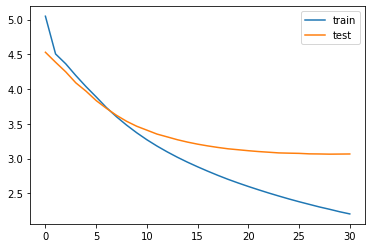

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

- 테스트 손실값은 15에폭 부터는 거의 줄어들지않는다

## 3) Attention mechanism
- 새로운 layer을 설계
- keras `AdditiveAttention` 사용
- Bahdanau-style attention 이라고 부르기도 한다<br>
[tensorflow doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)

In [74]:
from tensorflow.keras.layers import AdditiveAttention

# attention layer
attn_layer = AdditiveAttention(name='attention_layer')

# encoder & decoder's all hidden state of time steps -> attention layer
attn_out = attn_layer([decoder_outputs, encoder_output])

# connect attention output with decoder's hidden state
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out]) # 데이터의 가장 뒷차원에 붙인다

# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# define model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      3328000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

---

💡
**`Concatenate(axis=-1)`**
- 뒤에서부터 인덱싱하는 방식과 동일하다
- 만약 3차원이라면 2차원축 뒤에 붙이고, 만약 2차원이라면 1차원 축 뒤에 붙인다<br>
[blog](https://supermemi.tistory.com/entry/Tensorflow-2-tfconcat-axis-1-0-1-2)

---

- 아래 인퍼런스 모델을 구현하는 부분에서 어텐션 메커니즘을 만드는 부분을 빠뜨리고 모델학습을 진행한것을 확인했다!!!
- 어텐션메커니즘을 포함시킨 모델로 다시 학습진행

In [75]:
# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# early stop setting
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# checkpoint setting
checkpoint_filepath = 'abstract_summma_model_attention.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                             save_best_only=True, # Save only the best model
                             monitor='val_loss')  # Monitor validation loss

# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                       validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                        batch_size=256, callbacks=[es, checkpoint], epochs=50)

Epoch 1/50
308/308 [==============================] - 44s 125ms/step - loss: 4.0229 - val_loss: 3.3382
Epoch 2/50
308/308 [==============================] - 38s 125ms/step - loss: 3.0377 - val_loss: 3.0849
Epoch 3/50
308/308 [==============================] - 38s 123ms/step - loss: 2.7410 - val_loss: 2.9856
Epoch 4/50
308/308 [==============================] - 38s 124ms/step - loss: 2.5587 - val_loss: 2.9372
Epoch 5/50
308/308 [==============================] - 38s 123ms/step - loss: 2.4247 - val_loss: 2.9098
Epoch 6/50
308/308 [==============================] - 38s 124ms/step - loss: 2.3183 - val_loss: 2.9000
Epoch 7/50
308/308 [==============================] - 38s 124ms/step - loss: 2.2277 - val_loss: 2.8926
Epoch 8/50
308/308 [==============================] - 38s 124ms/step - loss: 2.1480 - val_loss: 2.8892
Epoch 9/50
308/308 [==============================] - 38s 124ms/step - loss: 2.0788 - val_loss: 2.8916
Epoch 10/50
308/308 [==============================] - 38s 124ms/step - l

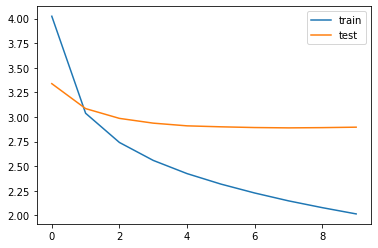

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

- 어텐션 메커니즘을 포함한 모델은 train loss는 더 낮게 나오지만 test loss는 거의 비슷한 값을 보인다
- 시간이 되면 recurrent dropout도 시도해봐야겠다

# Step 10. Inference model

---

💡
`Inference`
- **학습을 마친 모델로 실제 과제를 수행하는 것 혹은 과정**을 말한다


- seq2seq는 훈련할 때와 인퍼런스 단계의 방식이 다르다 => 모델 설계를 별도로 해줘야한다
- inference 단계에서는 `target 정답데이터`가 없다
- 만들어야할 문장의 길이만큼 디코더가 반복 구조로 동작해야함
- encoder model과 decoder model을 분리해서 설계한다

---


## 1) Inference - encoder layer

In [77]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, state_h, state_c])

# 이전 시점의 상태를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h,
                                                                            decoder_state_input_c])


- 문장의 다음 단어를 예측하기 위해서 initial state를 이전 시점의 상태로 사용한다
    - 뒤의 함수 decode_sequence()에서 구현
- 훈련 과정과는 다르게 LSTM의 리턴하는 은닉상태와 셀 상태인 state_h, state_c를 버리지 않는다

## 2) Inference - attention + decoder layer

In [78]:
# attention
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# decoder output layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

## `decode_sequence() 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수`

In [82]:
def decode_sequence(input_seq):
    # get encoder state from input
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # generate SOS token
    target_seq = np.zeros((1,1))
    target_seq[0,0] = tar_word_to_index['sostoken']
    
    stop_condition=False
    decoded_sentence = ''
    while not stop_condition: # stop_condition=True 될때까지 loop
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token != 'eostoken'):
            decoded_sentence += ' '+sampled_token
            
        # if 'reach eos' or 'over max length', stop
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1)):
            stop_condition = True
            
        
        # update target_seq - length 1
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        # update states
        e_h, e_c = h, c
        
    return decoded_sentence

# Step 11. Test model
- 정수 시퀀스를 텍스트 시퀀스로 변환해야 결과를 확인하는게 좋다

## `seq2text & seq2summary function`
- Text int sequence : padding 숫자 0을 제외
- Summary int seq : 숫자 0, sos & eos token index 제외

In [80]:
# 원문의 int seq -> text seq
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 int seq -> text seq
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+ ' '
    return temp
    

## 2) 실제 요약 vs 예측 요약 비교 + ROGUE metric
- 위에서 시도해봤던 ROGUE 지표를 사용해서 테스트 데이터 30개 샘플 비교

In [84]:
# Loop through the range 
for i in range(10, 30):
    original_text = seq2text(encoder_input_test[i])
    original_summary = seq2summary(decoder_input_test[i])
    predicted_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(predicted_summary, original_summary, avg=True)

    print('Original Text:', original_text)
    print('Original Summary:', original_summary)
    print('Predicted Summary:', predicted_summary)
    print('ROUGE Scores:', rouge_scores)
    print('\n')

Original Text: largest rome stretch kilometres open public seven years restoration laser technology named member roman family house tombs years old depict scenes saints martyrs 
Original Summary: rome largest with tombs to open after yrs 
Predicted Summary:  floating building opens in the world
ROUGE Scores: {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}


Original Text: uttar pradesh cm yogi adityanath awarded two lucknow based sisters sharp memory honey singh associated beti bachao beti padhao campaign answer around general knowledge questions within minutes government keep helping sisters ensure well inspire others cm yogi said 
Original Summary: up cm yogi awards each to sisters for sharp memory 
Predicted Summary:  up cm yogi adityanath launches his own brain
ROUGE Scores: {'rouge-1': {'r': 0.3, 'p': 0.375, 'f': 0.33333332839506175}, 'rouge-2': {'r': 0.2222222222222222, 'p': 0.2857142857142857, 'f':

- 요약본을 봤을때 제대로 요약이 되지 못한것 같다 (사실 엉망인것 같다..?)
- ROUGE score도 해석해보고싶은데 어떻게 해석해야하는지 모르겠다. 
- gpt 도움을 받아본다

> - **rouge-1**: **The F1 score is relatively low (0.2727)**, indicating a moderate balance between precision and recall. Improvement in both precision and recall could enhance the model's performance.<br>
> - **rouge-2**: The scores for bigrams are all zero, suggesting that **the model is not capturing two-word sequences well. This might be an area for improvement**.<br>
> - **rouge-l**: **The F1 score is relatively low (0.0909)**. It measures **the longest common subsequence, and a higher score indicates a better match**. Improvement in both precision and recall for this metric could be beneficial.


- 아주 더 성능개선이 필요하다!
- 시간이 된다면 트랜스포머를 사용해보고싶다!


**참고**
- [blog](https://huffon.github.io/2019/12/07/rouge/)
- [blog](https://sooftware.io/metric/)

---

💡
# 성능개선을 하려면!
- seq2seq + attention 조합을 더 좋게 수정
- beam search 빔서치
- pre-trained word embedding
- transformer : encoder + decoder 자체 구조를 새롭게 함

---

# `추출적 요약`
- 이미 본문에서 존재하는 단어구, 문장을 뽑아서 요약
- 패키지 [`Summa`](https://summanlp.github.io/textrank/)의 `summarize` 모듈을 활용해서 실습<br>
[참고] [Summa NLP](https://github.com/summanlp)

In [85]:
# summa install check 
!pip list | grep summa

summa                             1.2.0


In [86]:
import requests
from summa.summarizer import summarize

In [87]:
# load data - 추출적요약을 위한 데이터를 다시 만든다
data_for_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [88]:
# check data
data_for_summa.sample(10)

,headlines,text
3377,Threat to Goa CM's life due to Rafale files: C...,Goa Congress on Saturday wrote to President Ra...
83123,Adnan Sami to make Bollywood acting debut,Singer Adnan Sami is set to make his acting de...
75241,Virus-free pigs cloned for safer transplants f...,US-based scientists aiming to make pig organs ...
5321,Rahul plays chess with differently abled child...,Congress President Rahul Gandhi played chess w...
58298,300 engineering colleges to be shut down over ...,Around 300 private engineering colleges which ...
57592,Scientists unveil duck dinosaur that could run...,The study of a 75-million-year-old fossil smug...
43212,Vidarbha win Irani Cup after posting 800 in 1s...,Vidarbha claimed the Irani Cup trophy after po...
64548,Which were the most polluted cities in India o...,Rajasthan's Bhiwadi was the most polluted city...
24377,Body of newborn with paper stuffed in mouth fo...,The body of a newborn was found with toilet pa...
53909,"Redditor makes joke on Trump claiming credit, ...",A Redditor made a joke crediting Trump for com...


- text 데이터만 활용해서 추출적요약을 진행한다

---

💡

## `summarize()`

**Summa 의 summarize() 인자들**
> text (str) : 요약할 테스트<br>
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
words (int or None, optional) – 출력에 포함할 단어 수<br>
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다<br>
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환<br>


- 문장 토큰화를 별도로 하지 않아도 내부적으로 문장토큰화를 수행

---

In [101]:
# Randomly select 40 texts
random_sample = data_for_summa.sample(n=40, random_state=42)

# iterate through the rows and print the summarized text
for index, row in random_sample.iterrows():
    text_to_summarize = row['text']  # text 
    
    # check if the text is not empty
    if isinstance(text_to_summarize, str) and len(text_to_summarize.strip()) > 0:
        summarized_text = summarize(text_to_summarize, ratio=0.005) # 원문을 바로 넣고, 요약문으로 선택하는 문장개수는 원문의 0.005%로 설정
        
        # Print the summary for each text
        print(f'Summary for row {index + 1}:')
        print(summarized_text)
        print('\n') 

Summary for row 32572:



Summary for row 35185:



Summary for row 59998:



Summary for row 64666:



Summary for row 15344:



Summary for row 52899:



Summary for row 95150:



Summary for row 76916:



Summary for row 49399:



Summary for row 74037:



Summary for row 87659:



Summary for row 73015:



Summary for row 73027:



Summary for row 37832:



Summary for row 23956:



Summary for row 81908:



Summary for row 4625:



Summary for row 70369:



Summary for row 23375:



Summary for row 87882:



Summary for row 20748:



Summary for row 25890:



Summary for row 59976:



Summary for row 93365:



Summary for row 97870:



Summary for row 1802:



Summary for row 81625:



Summary for row 29700:



Summary for row 9925:



Summary for row 62050:



Summary for row 46057:



Summary for row 93064:



Summary for row 19879:



Summary for row 85994:



Summary for row 71002:



Summary for row 25803:



Summary for row 75312:



Summary for row 53944:



Summary for row

- 요약된 데이터가 출력되지않는다

In [102]:
# text data
text_data = data_for_summa['text']

# check data
text_data[:3]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
Name: text, dtype: object

In [103]:
# summarize 1 row data
print('Summary:')
print(summarize(text_data[0]))

Summary:



- 아! 지금 데이터는 object 타입이라서 안되는걸지도 모르겠다
- str 타입으로 변환시도

In [104]:
# text data which dtype is str
text_data = data_for_summa['text'].astype(str)

# check data
text_data[:3]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
Name: text, dtype: object

In [105]:
example = text_data[0].astype(str)
example

AttributeError: 'str' object has no attribute 'astype'

- 강훈님 도움을 받아서 코드를 수정

In [108]:
# Randomly select 40 texts
random_sample = data_for_summa.sample(n=40, random_state=42)
random_sample[:10]

,headlines,text
32571,K'taka students to get extra marks if parents ...,Students in Karnataka will get extra marks if ...
35184,Syria shoots down missiles fired at two air bases,Syrian anti-aircraft defences on Monday shot d...
59997,Dinosaur-like animal's fossil found in Uttarak...,A Dinosaur-like creature's fossil was found du...
64665,"UP may merge Shia, Sunni Waqf boards to preven...",The Uttar Pradesh government is planning to fo...
15343,Egypt actress gets 2 yrs jail for 'fake news' ...,Egyptian activist-actress Amal Fathy has been ...
52898,Jeff Bezos added more wealth in 2017 than GDP ...,World's richest person and Amazon CEO Jeff Bez...
95149,Bangladeshi captain Mortaza announces retireme...,Bangladesh cricket team's limited overs captai...
76915,Mexican drug lord El Chapo questions US extrad...,Mexican drug lord Joaquin 'El Chapo' Guzman ha...
49398,N Korea supplies ballistic missiles to Myanmar...,Independent United Nations (UN) monitors have ...
74036,Thenga mila hamme: Harbhajan responds to home ...,After reports of three Amrapali Group companie...


In [109]:
# index 얻기 시도
for index, row in random_sample['text'].iterrows():
    print(f'Index: {index}, Values: {row}')

AttributeError: 'Series' object has no attribute 'iterrows'

In [114]:
# index 얻기 시도 2
random_sample_idx = random_sample['text'].index
random_sample_idx

Int64Index([32571, 35184, 59997, 64665, 15343, 52898, 95149, 76915, 49398,
            74036, 87658, 73014, 73026, 37831, 23955, 81907,  4624, 70368,
            23374, 87881, 20747, 25889, 59975, 93364, 97869,  1801, 81624,
            29699,  9924, 62049, 46056, 93063, 19878, 85993, 71001, 25802,
            75311, 53943, 68955, 17566],
           dtype='int64')

In [137]:
# iterate through the rows and print the summarized text
for idx, text in enumerate(random_sample['text']):
    summary = summarize(text, ratio=0.5) # 원문을 바로 넣고, 요약문으로 선택하는 문장개수는 원문의 50%로 설정
    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(summary, text, avg=True)
    
    # Extract only the F1 score from the ROUGE scores
    f1_score = rouge_scores['rouge-1']['f']
    
    # Print the summary for each text
    print('index:', random_sample_idx[idx])
    print('Original Text:', text)
    print('Predicted Summary:', summary)
    print('ROUGE F1 Score:', f1_score)
    print('\n')

index: 13370
Original Text: Sushmita Sen is dating model Rohman Shawl whom she had met at a fashion event in August, as per reports. Rohman was spotted cheering for Sushmita at Neeta Lulla's fashion show a few days ago where he was also seen interacting with Sushmita's daughters Renee and Alisah, reports suggested. Sushmita was earlier said to be dating hotelier Ritik Bhasin. 
Predicted Summary: Sushmita Sen is dating model Rohman Shawl whom she had met at a fashion event in August, as per reports.
ROUGE F1 Score: 0.5714285673469389


index: 24057
Original Text: Micro-blogging site Twitter on Friday revealed its earnings for the second quarter of 2018 where it stated that its monthly active users dropped from 336 million in Q1 to 335 million in Q2. The company saw revenue of $711 million, up from $665 million in the last quarter. Twitter reported a net income of $100 million, its third-straight profitable quarter.
Predicted Summary: Twitter reported a net income of $100 million, its th

ValueError: Hypothesis is empty.

**formula for F1 score**
$$F1 = \frac{2⋅Precision⋅Recall}{Precision+Recall}$$


- f1 score가 높을수록 과한 중복없이 요약이 많은 관련 정보를 캡처해서 좋은 요약을 만들었다는걸 의미한다고 한다.
- 대체로 `0.5` 을 맴도는 점수를 보여준다.
- 확실히 추출적요약이 추상적요약보다 더 좋은 결과를 보여준다


- 회고를 미리 써두고 트랜스포머 사용을 시도해본다.

---
---

# Summary

- NLP 내용은 잊은지 오래된 시점에서 모델을 구현해서 결과값을 확인하고, 해석까지 하는 작업을 하니 굉장히 힘들고 어려웠다.
- 최대한 어떤 플로우로 진행되는지 파악한다는 기분으로 진행했고, 어떤 개념을 공부해야할지 확인한다고 생각하니 마음이 한결 가벼워졌다.
- CV도 데이터 전처리가 중요했지만 NLP는 훨씬 더 데이터전처리가 중요하다고 느껴졌고, 엔지니어의 역할이 중요한것처럼 느껴진다.


---

# KPT

**[KEEP]**
- 초반에 수치값이 많이 나와서 스트레스르르 많이 받았고, 너무 생소한 내용들이라 어려웠는데 마인드컨트롤을 하며 학습했다.


**[PROBLEM]**
- 데이터프레임 활용하는 방법을 많이 잊어서 어떻게 데이터를 다뤄야하는지 좀 헤맸다. 
- 평가지표에 대한 정리가 안되어있어서 ROUGE 값이 크면 좋은건지, 작으면 좋은건지 해석하는게 어려웠다.
- 숫자 데이터가 많이 나왔는데 CV와 다르게 제대로 나온건지 확인할수가 없어서 자신이 없었다.


**[TRY]**
- 틈틈이 판다스 데이터프레임 문제를 풀어본다.
- 이후 노드에서 나오는 NLP부분에서는 관련 자료도 함께 읽어보고 더 꼼꼼하게 공부해본다
- 평가지표 부분에서 찾아둔 블로그와 관련 자료를 읽어보며 내용을 정리한다.


---
---

💡
# Transformer 모델 실험
- 관련 지식 하나도 없어서 모델을 직접 구현하는건 어려울것 같고, 다행히 [위키독스 자료](https://wikidocs.net/31379)에서 트랜스포머 설명을 찾았다. 이를 바탕으로 테스트를 해본다
- 해보려고했는데 너무 어려운 내용이라 [Hugging Face](https://icedhotchoco.tistory.com/entry/DAY-83)에서 트랜스포머 라이브러리를 가져와서 실습해보는 자료를 찾았다. 이를 바탕으로 실험
    - [Hugging face - Transformer quicktour](https://huggingface.co/docs/transformers/quicktour)
    - [SummarizationPipeline](https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/pipelines#transformers.SummarizationPipeline)

In [133]:
# load transformer pipeline 
from transformers import pipeline

In [134]:
# Randomly select 40 texts
random_sample = data_for_summa.sample(n=40, random_state=1004)

random_sample['text'][:5]

13370    Sushmita Sen is dating model Rohman Shawl whom...
24057    Micro-blogging site Twitter on Friday revealed...
42500    The Centre on Wednesday cleared a plan to set ...
67384    A Chandigarh court has rejected a surrender pl...
9404     A selfie has saved a US man from a possible pr...
Name: text, dtype: object

In [135]:
# make summarization pipeline
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [136]:
# original index 얻기
random_sample_idx = random_sample['text'].index
random_sample_idx

Int64Index([13370, 24057, 42500, 67384,  9404, 81670, 96525, 30846, 73029,
            52230,  9834, 22931, 19631, 76864, 92696, 46321, 23420, 39753,
            48225, 92872, 28942, 94481, 44515, 77671, 69310,  1877,  5656,
            43402, 91277, 33170, 81495, 15288, 95623, 95814, 73421, 95798,
            17371,  8258, 66810, 70001],
           dtype='int64')



- original_text: The text you want to summarize
- max_length: Maximum number of words in the generated summary
- min_length: Minimum number of words in the generated summary
- length_penalty: A factor influencing the length of the summary
- num_beams: The number of different ways to explore possible summaries

In [142]:
# iterate through the rows and print the summarized text
for idx, text in enumerate(random_sample['text']):
    dict_summary = summarizer(text, min_length=5, max_length=20)
    summary = dict_summary[0]['summary_text']
    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(summary, text, avg=True)
    
    # Extract only the F1 score from the ROUGE scores
    f1_score = rouge_scores['rouge-1']['f']
    
    # Print the summary for each text
    print('index:', random_sample_idx[idx])
    print('Original Text:', text)
    print('Predicted Summary:', summary)
    print('ROUGE F1 Score:', f1_score)
    print('\n')

index: 13370
Original Text: Sushmita Sen is dating model Rohman Shawl whom she had met at a fashion event in August, as per reports. Rohman was spotted cheering for Sushmita at Neeta Lulla's fashion show a few days ago where he was also seen interacting with Sushmita's daughters Renee and Alisah, reports suggested. Sushmita was earlier said to be dating hotelier Ritik Bhasin. 
Predicted Summary:  Rohman Shawl was spotted cheering for Sushmita at Neeta Lulla
ROUGE F1 Score: 0.29999999722222226


index: 24057
Original Text: Micro-blogging site Twitter on Friday revealed its earnings for the second quarter of 2018 where it stated that its monthly active users dropped from 336 million in Q1 to 335 million in Q2. The company saw revenue of $711 million, up from $665 million in the last quarter. Twitter reported a net income of $100 million, its third-straight profitable quarter.
Predicted Summary:  Twitter reported a net income of $100 million, its third-straight profitable quarter .
ROUGE 

- 생각해보니 이 요약에는 데이터 전처리를 하지 않아서 트랜스포머인데도 f1 score가 크게 좋지않은걸까 싶다.
- 데이터 전처리도 완료한후 트랜스포머를 다시 사용해봐야겠다